In [1]:
""" Imports """
import re

import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc

from string import punctuation

from sklearn.base import BaseEstimator, TransformerMixin

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display, Markdown, HTML

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kapuchinka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

stop_words = list(punctuation)
stop_words.extend(stopwords.words('russian'))
tokenizer = RegexpTokenizer(r'\w+')

snow_stemmer = SnowballStemmer(language='russian')

In [3]:
def open_dataset():
    l_dataset = pd.read_csv('./resources/dataset.csv')
    display(Markdown(f"""#### Исходный Датасет"""))
    display(l_dataset)
    return l_dataset

In [4]:
def preprocess_texts_natasha(p_texts):
    processed_texts = []
    
    for text in p_texts:
        doc = Doc(text)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        lemmas = []
        for token in doc.tokens:
            token.lemmatize(morph_vocab)
            stem = snow_stemmer.stem(token.lemma)
            lemmas.append(stem)
        processed_texts.append(" ".join(lemmas))
        
    return processed_texts

In [5]:
def clean_texts(p_texts):
    text = p_texts.lower()
    text = re.sub(r"[^а-яА-ЯёЁ\s]", " ", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    return " ".join(tokens)

In [6]:
def build_text_pipeline():
    class NatashaPreprocessor(BaseEstimator, TransformerMixin):
        def fit(self, X, y=None):
            return self
        def transform(self, X):
            return [clean_texts(text) for text in preprocess_texts_natasha(X)]
    pipeline = Pipeline([
        ('preprocessing', NatashaPreprocessor()),
        ('vectorizer', TfidfVectorizer())
    ])
    return pipeline

In [7]:
def get_tokens(param_dataset, sentences_column, labels_column):
    sentences = param_dataset[sentences_column].apply(str.split).tolist()
    labels = param_dataset[labels_column].values
    return {
        'sentences': sentences, 
        'labels': labels
    }

In [8]:
def vectorize_text(param_model, param_texts):
    vec_size = param_model.vector_size
    vectors = []
    for tokens in param_texts:
        tokens = [t for t in tokens if t in param_model.wv]
        if tokens:
            vectors.append(np.mean(param_model.wv[tokens], axis=0))
        else:
            vectors.append(np.zeros(vec_size))
    return np.array(vectors)

In [9]:
def skip_gram_learning(param_window_values, param_sentences, param_labels):
    local_accuracies_sg = []
    analyze_data = []
    local_data_sg_for_reports = []
    
    for window in param_window_values:
        local_sg_model = Word2Vec(param_sentences, vector_size=100, window=window, min_count=2, sg=1, seed=42)
        X_vec = vectorize_text(local_sg_model, param_sentences)
    
        X_train, X_test, Y_train, Y_test = train_test_split(X_vec, param_labels, test_size=0.2, random_state=42)
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, Y_train)
        acc = clf.score(X_test, Y_test)
        Y_pred = clf.predict(X_test)
        local_accuracies_sg.append(acc)
        
        analyze_data.append([
            window,
            round(acc, 4)
        ]);
        
        local_data_sg_for_reports.append([
            Y_test,
            Y_pred
        ]);
        
    columns = ['Window', 'Accuracy']
    df = pd.DataFrame(analyze_data, columns=columns)
    
    display(Markdown(f""" #### Результат обучения Skip-Gram """))
    display(df.style.hide(axis="index"))
    return local_sg_model, local_accuracies_sg, local_data_sg_for_reports

In [10]:
def cbow_learning(param_window_values, param_sentences, param_labels):
    local_accuracies_cbow = []
    analyze_data = []
    local_data_cbow_for_reports = []
    
    for window in param_window_values:
        local_cbow_model = Word2Vec(param_sentences, vector_size=100, window=window, min_count=2, sg=0, seed=42)
        X_vec_cb = vectorize_text(local_cbow_model, param_sentences)
    
        X_train, X_test, Y_train, Y_test = train_test_split(X_vec_cb, param_labels, test_size=0.2, random_state=42)
        clf_cb = LogisticRegression(max_iter=1000)
        clf_cb.fit(X_train, Y_train)
        acc_cb = clf_cb.score(X_test, Y_test)
        Y_pred = clf_cb.predict(X_test)
        local_accuracies_cbow.append(acc_cb)
        
        analyze_data.append([
            window,
            round(acc_cb, 4)
        ]);
        
        local_data_cbow_for_reports.append([
            Y_test,
            Y_pred
        ]);
        
    columns = ['Window', 'Accuracy']
    df = pd.DataFrame(analyze_data, columns=columns)
    
    display(Markdown(f""" #### Результат обучения CBOW """))
    display(df.style.hide(axis="index"))
    return local_cbow_model, local_accuracies_cbow, local_data_cbow_for_reports

In [11]:
def plot_accurancy_dependence(param_window_values, param_accuracies_sg, param_accuracies_cbow):
    plt.figure(figsize=(8, 5))
    plt.plot(param_window_values, param_accuracies_sg, marker='o', label='Skip-Gram')
    plt.plot(param_window_values, param_accuracies_cbow, marker='s', label='CBOW')
    plt.title("Зависимость качества классификации от размера окна")
    plt.xlabel("Размер окна")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
def get_report(param_window_values, param_data, param_name_model):
    html_content = """
    <div style="display: flex; flex-wrap: wrap; gap: 2px; margin: 0; padding: 0;">
    """

    for i in range(len(param_window_values)):
        report_dict = classification_report(param_data[i][0], param_data[i][1], output_dict=True)
        df_report = pd.DataFrame(report_dict).transpose()

        if 'accuracy' in df_report.index:
            accuracy_row = df_report.loc[['accuracy']]
            df_report = df_report.drop('accuracy')
            df_report = pd.concat([df_report, accuracy_row])

        report_html = f"""
        <div style="flex: 1; min-width: 350px; margin: 0; padding: 0;">
            <h4 style="margin: 0 0 2px 0; padding: 0; font-size: 12px;">{param_name_model} (window={param_window_values[i]})</h4>
            {df_report.style.format("{:.2f}")
                .set_table_styles([
                    {'selector': '', 'props': [('font-size', '12px')]},
                    {'selector': 'th, td', 'props': [
                        ('padding', '3px 6px'),
                        ('min-width', '50px')
                    ]},
                    {'selector': 'th', 'props': [('white-space', 'nowrap')]}
                ])
                .set_table_attributes('style="margin: 0; padding: 0;"')
                .to_html()}
        </div>
        """
        html_content += report_html

    html_content += "</div>"
    display(HTML(html_content))

In [13]:
def get_table_embeddings(param_model, param_name_model):
    local_words = list(param_model.wv.index_to_key[:50])
    local_vectors = [param_model.wv[word] for word in local_words]
    embedding_df = pd.DataFrame(local_vectors, index=local_words)
    embedding_df.reset_index(inplace=True)
    embedding_df.rename(columns={"index": "word"}, inplace=True)
    
    styled_df = embedding_df.style \
        .set_caption(f"Эмбеддинги для первых 50 слов ({param_name_model})") \
        .background_gradient(cmap="coolwarm", axis=1) \
        .format(precision=3) \
        .hide(axis="index")

    display(styled_df)

    html = styled_df.to_html(encoding='utf-8')
    full_html = f"""
        <!DOCTYPE html>
        <html>
            <head>
                <meta charset="UTF-8">
                <title>Эмбеддинги {param_name_model}</title>
            </head>
            <body>
                {html}
            </body>
        </html>
    """
    
    with open(f"./out/{param_name_model}_emdebbings.html", "w", encoding='utf-8') as f:
        f.write(full_html)
    
    return local_words, embedding_df

In [14]:
def calc_cosine_distances(param_df, param_words, param_name_model):
    vector_values = param_df.drop(columns='word').values
    
    distance_matrix = cosine_distances(vector_values)
    
    distance_df = pd.DataFrame(distance_matrix, index=param_words, columns=param_words)
    
    styled_df = distance_df \
        .style.set_caption(f"Косинусные расстояния между словами ({param_name_model})") \
        .background_gradient(cmap="magma", axis=1) \
        .format(precision=3)
    
    display(styled_df)
    
    html = styled_df.to_html(encoding='utf-8')
    full_html = f"""
        <!DOCTYPE html>
        <html>
            <head>
                <meta charset="UTF-8">
                <title>Эмбеддинги {param_name_model}</title>
            </head>
            <body>
                {html}
            </body>
        </html>
    """
    
    with open(f"./out/{param_name_model}_cosine_distances.html", "w", encoding='utf-8') as f:
        f.write(full_html)

In [15]:
def get_visualization_pca(param_model, param_words, param_name_model):
    X = param_model.wv[param_words]
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1])
    for i, word in enumerate(param_words):
        plt.text(X_2d[i, 0]+0.01, X_2d[i, 1]+0.01, word, fontsize=9)
    display(Markdown(f""" ### Визуализация PCA {param_name_model} """))
    plt.title(f"2D визуализация эмбеддингов слов ({param_name_model})")
    plt.grid(True)
    plt.show()

In [16]:
dataset = open_dataset()

preprocess_result = preprocess_texts_natasha(dataset['text'])
dataset['clean_text'] = dataset['text'].apply(clean_texts)

pipeline = build_text_pipeline()
X_transformed = pipeline.fit_transform(dataset['clean_text'].head(10))
transformed_df = pd.DataFrame(X_transformed.toarray())

display(Markdown(f"""#### Датасет после препроцессинга """))
display(dataset)

#### Исходный Датасет

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,776944963,volleyball,Стал известен календарь мужской сборной России...


#### Датасет после препроцессинга 

,oid,category,text,clean_text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,волшебные фото виктория поплавская евгениямедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,возвращение подземелье треша эйфория тупости ж...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,лучшие чешские вратари доминик доминатор гашек...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,валрак решил подкормить сильно свежими слухами...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,шестеркин затаскивает рейнджерс финал восточно...
...,...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...,битная буря снова накрыла пикселями автомобиль...
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...,ира сидоркова объясняет сказалась машине резул...
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...,ракетка мира хорват марин чилич обыграл испанц...
38738,776944963,volleyball,Стал известен календарь мужской сборной России...,стал известен календарь мужской сборной россии...


In [17]:
tokens = get_tokens(dataset, 'clean_text', 'category')
window_values = [2, 4, 6, 8] 

sg_model, accuracies_sg, data_sg_for_reports = skip_gram_learning(window_values, tokens['sentences'], tokens['labels'])
cbow_model, accuracies_cbow, data_cbow_for_reports = cbow_learning(window_values, tokens['sentences'], tokens['labels']) 

 #### Результат обучения Skip-Gram 

Window,Accuracy
2,0.585300
4,0.643800
6,0.685500
8,0.708200


 #### Результат обучения CBOW 

Window,Accuracy
2,0.494700
4,0.515700
6,0.535100
8,0.547200


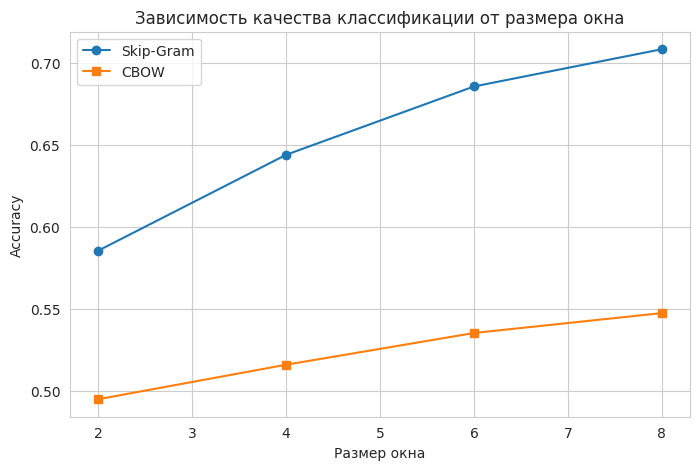

In [18]:
plot_accurancy_dependence(window_values, accuracies_sg, accuracies_cbow)

In [19]:
display(Markdown(f""" ### Отчёт классификации Skip-Gram """))
get_report(window_values, data_sg_for_reports, 'Skip-Gram')

 ### Отчёт классификации Skip-Gram 

,precision,recall,f1-score,support
athletics,0.72,0.76,0.74,541.00
autosport,0.62,0.59,0.61,648.00
basketball,0.72,0.60,0.65,559.00
boardgames,0.59,0.72,0.65,598.00
esport,0.43,0.42,0.43,590.00
extreme,0.41,0.57,0.48,633.00
football,0.50,0.44,0.47,585.00
hockey,0.62,0.59,0.61,622.00
martial_arts,0.54,0.55,0.54,584.00
motosport,0.58,0.47,0.52,623.00


In [20]:
display(Markdown(f""" ### Отчёт классификации CBOW """))
get_report(window_values, data_cbow_for_reports, 'CBOW')

 ### Отчёт классификации CBOW 

,precision,recall,f1-score,support
athletics,0.69,0.68,0.68,541.00
autosport,0.51,0.53,0.52,648.00
basketball,0.58,0.45,0.51,559.00
boardgames,0.48,0.66,0.56,598.00
esport,0.35,0.33,0.34,590.00
extreme,0.36,0.55,0.44,633.00
football,0.43,0.32,0.37,585.00
hockey,0.54,0.48,0.51,622.00
martial_arts,0.40,0.48,0.43,584.00
motosport,0.47,0.35,0.40,623.00


In [21]:
words_sg, embedding_df_sg = get_table_embeddings(sg_model, 'Skip-Gram')
words_cbow, embedding_df_cbow = get_table_embeddings(cbow_model, 'CBOW')

In [22]:
calc_cosine_distances(embedding_df_sg, words_sg, 'Skip-Gram')
calc_cosine_distances(embedding_df_cbow, words_cbow, 'CBOW')

,это,очень,года,время,россии,сегодня,мира,также,команды,м,который,место,день,которые,просто,лет,всем,году,игры,матч,нужно,бег,сезона,против,спорт,гран,команда,будут,нам,чемпионата,видео,сезоне,фото,стал,турнира,свой,друзья,поэтому,г,первый,сезон,матча,й,сказал,пока,матче,год,очков,второй,гонки
это,0.000,0.730,0.905,0.865,0.830,0.790,0.845,0.925,0.875,0.913,0.849,0.870,0.825,0.961,0.667,0.856,0.836,0.779,0.862,0.792,0.709,0.814,0.842,0.923,0.735,0.785,0.951,0.839,0.679,0.850,0.817,0.845,0.769,0.889,0.855,0.833,0.871,0.653,0.897,0.842,0.840,0.753,0.999,0.715,0.656,0.869,0.629,0.855,0.881,0.735
очень,0.730,0.000,0.896,0.883,0.901,0.872,0.892,0.881,0.910,0.912,0.878,0.943,0.853,0.882,0.739,0.868,0.871,0.913,0.798,0.767,0.901,0.770,0.796,0.734,0.842,1.024,0.890,0.985,0.745,0.914,0.847,0.833,0.814,0.878,0.886,0.864,0.784,0.544,0.890,0.811,0.778,0.833,0.976,0.574,0.707,0.879,0.850,0.820,0.847,0.726
года,0.905,0.896,0.000,0.826,0.805,0.903,0.740,0.931,0.814,0.834,0.846,0.858,0.930,0.862,0.786,0.641,0.889,0.638,0.826,0.956,0.929,1.010,0.593,0.812,0.909,0.743,0.754,0.756,0.839,0.727,0.822,0.725,0.929,0.723,0.723,0.800,0.909,0.966,0.673,0.732,0.667,0.827,0.832,0.876,0.761,0.899,0.530,0.789,0.806,0.783
время,0.865,0.883,0.826,0.000,0.852,0.836,0.932,0.870,0.949,0.955,0.962,0.800,0.873,0.933,0.875,0.890,0.940,0.909,0.867,0.925,0.874,0.831,0.832,0.836,0.976,0.851,0.921,0.876,0.883,0.925,0.807,0.808,0.865,0.913,0.905,0.884,0.909,0.782,0.901,0.852,0.754,0.816,0.937,0.821,0.791,0.917,0.851,0.991,0.755,0.764
россии,0.830,0.901,0.805,0.852,0.000,0.868,0.715,0.962,0.852,0.908,1.008,0.862,0.864,0.999,0.977,0.847,0.828,0.844,0.755,0.831,0.950,0.824,0.754,0.917,0.749,0.925,0.829,0.821,0.861,0.635,0.880,0.810,0.843,0.918,0.700,0.879,0.815,0.865,0.779,0.783,0.744,0.847,1.065,0.892,0.868,0.875,0.792,0.836,0.898,0.759
сегодня,0.790,0.872,0.903,0.836,0.868,0.000,0.830,0.885,0.832,0.923,0.954,0.907,0.631,0.980,0.819,0.914,0.918,0.795,0.874,0.721,0.922,0.950,0.846,0.913,0.886,0.880,0.785,0.889,0.805,0.715,0.859,0.837,0.875,0.897,0.891,0.761,0.768,0.749,0.982,0.743,0.812,0.897,0.739,0.874,0.597,0.827,0.827,0.819,0.749,0.677
мира,0.845,0.892,0.740,0.932,0.715,0.830,0.000,0.785,0.872,0.788,0.769,0.796,0.821,0.984,0.818,0.864,0.869,0.687,1.033,0.902,0.914,0.830,0.793,0.893,0.880,0.694,0.879,0.883,0.868,0.592,0.896,0.778,0.834,0.788,0.619,0.853,0.895,0.923,0.863,0.920,0.773,0.886,0.736,0.732,0.807,0.815,0.740,0.756,0.781,0.709
также,0.925,0.881,0.931,0.870,0.962,0.885,0.785,0.000,0.907,0.921,0.724,0.886,0.933,0.777,0.743,0.885,0.886,0.722,0.837,0.856,0.884,1.043,0.856,0.953,0.940,0.827,0.837,0.713,0.891,0.844,0.827,0.821,0.978,0.857,0.952,0.813,0.961,0.797,0.972,0.855,0.775,0.909,0.931,0.954,0.772,0.888,0.871,0.856,0.750,0.818
команды,0.875,0.910,0.814,0.949,0.852,0.832,0.872,0.907,0.000,0.834,0.847,0.715,0.831,0.781,0.923,0.905,0.870,0.712,0.761,0.922,0.987,0.859,0.727,0.848,0.851,0.779,0.444,0.819,0.766,0.708,0.912,0.727,0.800,0.774,0.691,0.768,0.859,0.853,0.834,0.828,0.756,0.807,0.893,0.838,0.910,0.845,0.714,0.708,0.814,0.740
м,0.913,0.912,0.834,0.955,0.908,0.923,0.788,0.921,0.834,0.000,0.934,0.811,0.802,0.959,0.902,0.908,0.866,0.762,0.937,0.921,1.035,0.832,0.800,0.804,0.895,0.799,0.845,0.988,0.974,0.748,0.864,0.767,0.800,0.832,0.810,0.810,0.805,0.936,0.770,0.837,0.782,0.980,0.753,0.853,0.849,0.759,0.778,0.743,0.766,0.865


,это,очень,года,время,россии,сегодня,мира,также,команды,м,который,место,день,которые,просто,лет,всем,году,игры,матч,нужно,бег,сезона,против,спорт,гран,команда,будут,нам,чемпионата,видео,сезоне,фото,стал,турнира,свой,друзья,поэтому,г,первый,сезон,матча,й,сказал,пока,матче,год,очков,второй,гонки
это,0.000,0.269,0.864,0.611,0.883,0.623,0.828,0.897,0.957,1.036,0.621,0.827,0.636,0.591,0.260,0.783,0.704,0.770,0.766,0.650,0.293,0.571,0.784,0.679,0.608,0.818,0.580,0.728,0.459,0.836,0.822,0.800,1.104,0.892,1.052,0.764,0.855,0.256,1.041,0.703,0.683,0.865,0.776,0.419,0.367,0.880,0.637,0.776,0.718,0.662
очень,0.269,0.000,1.028,0.702,0.877,0.466,0.883,0.946,0.709,0.858,0.674,0.887,0.687,0.555,0.218,0.877,0.551,0.681,0.885,0.619,0.351,0.646,0.752,0.574,0.764,0.717,0.471,0.629,0.288,0.783,0.819,0.677,1.084,0.765,0.940,0.855,0.757,0.204,1.061,0.648,0.643,0.776,0.667,0.347,0.305,0.736,0.724,0.761,0.547,0.540
года,0.864,1.028,0.000,0.780,0.702,0.807,0.607,0.672,0.681,0.808,0.322,0.844,0.760,0.982,1.067,0.393,0.971,0.267,0.950,0.877,0.959,1.046,0.209,0.818,1.007,0.360,0.589,0.781,0.998,0.453,0.946,0.482,0.917,0.507,0.761,0.819,1.063,0.844,0.773,0.644,0.276,0.762,0.724,0.665,0.610,0.822,0.229,0.681,0.681,0.521
время,0.611,0.702,0.780,0.000,1.093,0.830,1.080,0.730,0.861,0.851,0.774,0.662,0.896,0.682,0.716,0.933,0.902,0.841,0.799,0.917,0.541,0.664,0.633,0.907,0.791,0.695,0.789,0.650,0.688,0.803,0.736,0.806,0.969,0.895,0.994,1.000,0.838,0.541,0.944,0.957,0.867,0.823,0.879,0.740,0.548,0.911,0.927,0.760,0.785,0.529
россии,0.883,0.877,0.702,1.093,0.000,0.777,0.310,0.657,0.617,1.020,0.841,0.817,0.791,0.794,1.053,0.598,0.898,0.609,1.057,0.816,1.086,0.925,0.715,0.783,0.706,0.755,0.520,0.646,0.968,0.649,0.947,0.707,0.868,0.805,0.685,1.170,0.797,0.948,0.562,0.811,0.682,0.848,0.922,0.654,0.814,0.822,0.709,0.958,0.899,0.783
сегодня,0.623,0.466,0.807,0.830,0.777,0.000,0.902,1.072,0.663,0.987,0.608,0.851,0.292,0.941,0.692,0.789,0.510,0.745,0.800,0.331,0.710,0.889,0.595,0.557,0.887,0.718,0.379,0.735,0.504,0.573,0.818,0.699,1.006,0.746,0.684,0.668,0.576,0.588,0.926,0.311,0.457,0.486,0.447,0.588,0.510,0.588,0.618,0.694,0.382,0.628
мира,0.828,0.883,0.607,1.080,0.310,0.902,0.000,0.696,0.884,0.864,0.773,0.754,0.965,0.894,0.908,0.707,0.939,0.511,1.146,1.017,1.049,0.820,0.617,0.846,0.777,0.527,0.677,0.831,1.012,0.684,0.975,0.696,0.935,0.605,0.647,1.155,0.917,0.883,0.840,0.841,0.722,0.955,0.838,0.629,0.733,0.836,0.714,0.799,0.754,0.564
также,0.897,0.946,0.672,0.730,0.657,1.072,0.696,0.000,0.502,0.987,0.644,0.862,1.286,0.424,0.863,0.936,1.003,0.632,0.513,0.853,0.669,0.903,0.522,0.570,0.806,0.685,0.690,0.479,0.788,0.616,0.804,0.465,0.975,0.677,0.656,1.068,0.909,0.703,0.929,1.116,0.797,0.665,1.064,0.640,0.629,0.596,0.894,0.570,0.958,0.756
команды,0.957,0.709,0.681,0.861,0.617,0.663,0.884,0.502,0.000,0.857,0.589,0.668,0.905,0.627,0.944,0.795,0.879,0.472,0.786,0.624,0.833,1.192,0.414,0.534,1.173,0.642,0.272,0.456,0.643,0.477,0.979,0.300,0.948,0.477,0.503,0.926,0.952,0.711,0.807,0.738,0.503,0.505,0.712,0.665,0.612,0.480,0.681,0.513,0.581,0.656
м,1.036,0.858,0.808,0.851,1.020,0.987,0.864,0.987,0.857,0.000,0.894,0.804,0.870,0.956,0.957,0.643,0.909,0.537,1.183,1.050,1.043,0.635,0.832,0.984,0.851,0.652,0.920,0.917,1.043,0.736,0.963,0.702,0.818,0.484,0.711,0.762,0.867,0.983,0.422,0.688,0.731,0.924,0.409,1.100,1.028,0.770,0.792,0.703,0.528,0.562


 ### Визуализация PCA Skip-Gram 

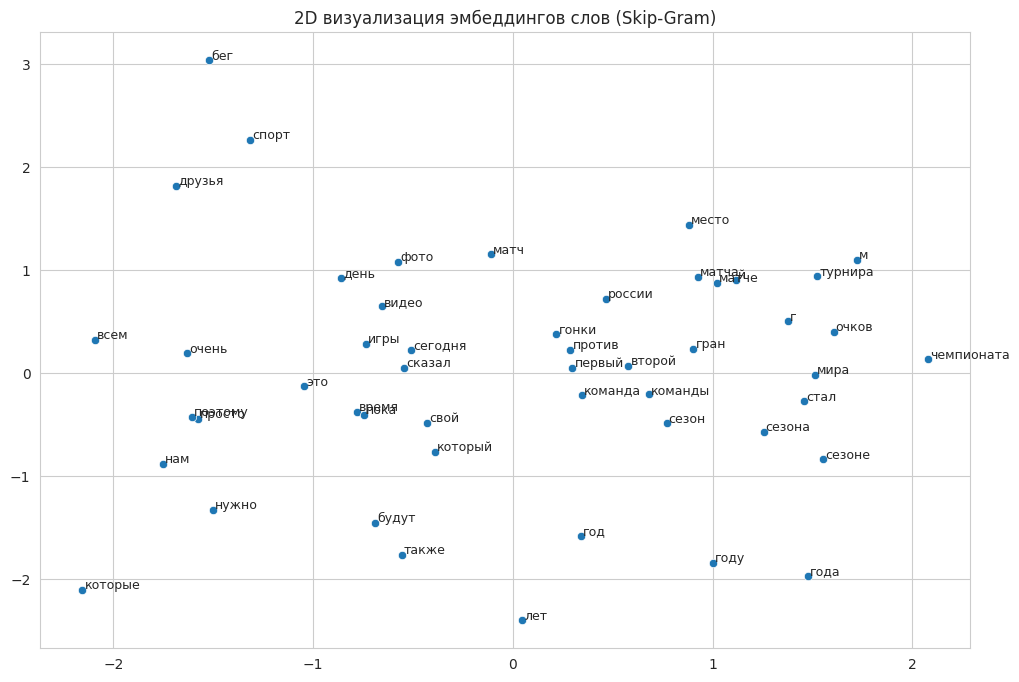

 ### Визуализация PCA CBOW 

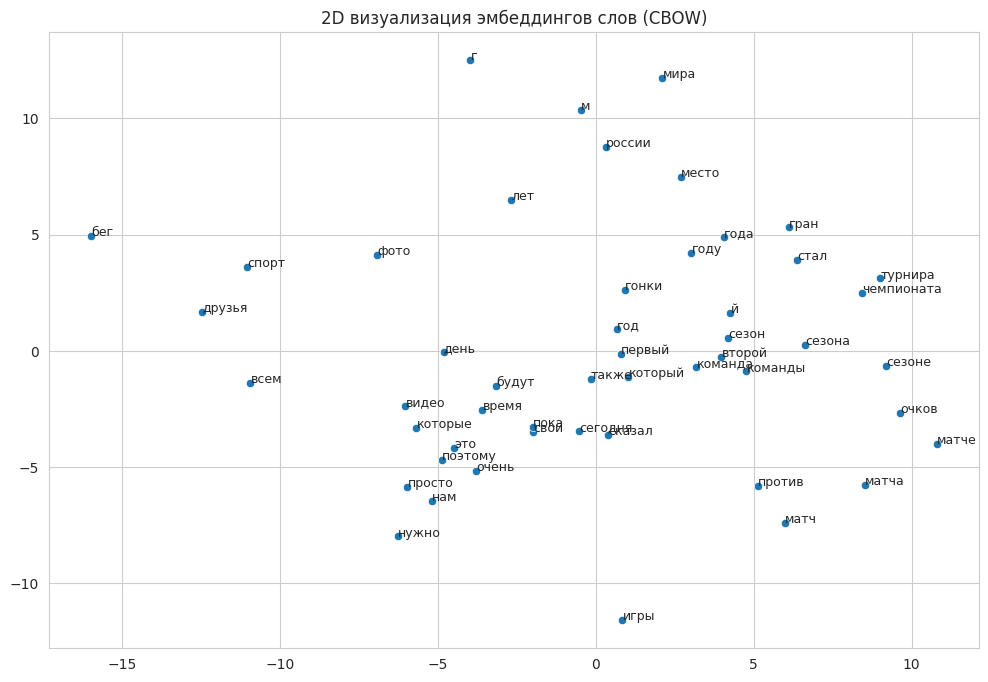

In [23]:
get_visualization_pca(sg_model, words_sg, 'Skip-Gram')
get_visualization_pca(cbow_model, words_cbow, 'CBOW')